# Define Python Functions

In [ ]:
import scipy
import os
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Image
from astropy.io import ascii
from astropy.time import Time
%matplotlib inline

# Download Supernova Spectral Data

In [ ]:
# Download files
for obj in ['2016gkg','2021pfs','2019yvr','2017ein','2022mxv','2020tlf','2019abn']:
    if os.path.exists(f'{obj}.csv'): 
        print(f'{obj}.csv exists')
        continue
    cmd = f'wget https://raw.githubusercontent.com/CIERA-Northwestern/REACHpy/main/Projects/SN_classification/{obj}.csv'
    os.system(cmd)

# Defining a spectrum object to help analyze data

In [ ]:
def is_number(val):
    try:
        x = float(val)
        return(True)
    except ValueError:
        return(False)

class spectrum(object):
    def __init__(self, specfile):
        
        self.wavelength = None
        self.flux = None
        self.flux_err = None
        
        self.meta = {}
        
        self.load_spectrum(specfile)
        
    def load_spectrum(self, filename):
        
        table = ascii.read(filename)
        self.wavelength = table['wavelength']
        self.flux = table['flux']
        self.flux_err = table['fluxerr']
        
        meta = table.meta['comments']
        for pair in meta:
            data = pair.split(':')
            key = data[0]
            val = ':'.join(data[1:])
            key = key.strip() ; val = val.strip()
            if is_number(val):
                self.meta[key]=float(val)
            else:
                self.meta[key]=val
        
        self.meta['name'] = filename.replace('.csv','')
        
        if 'OBS_DATE' in self.meta.keys():
            val = self.meta['OBS_DATE']
            if '+' in val: val = val.split('+')[0]
            self.meta['OBS_DATE'] = Time(val)
    
    def get_rest_spectrum(self, normalize=True):
        
        wave = None
        flux = None
        if 'REDSHIFT' in self.meta.keys():
            wave = self.wavelength/(1+self.meta['REDSHIFT'])
        else:
            wave = self.wavelength
        if normalize:
            flux = self.flux / np.mean(self.flux)
        else:
            flux = self.flux
            
        return(wave, flux)
    
    def get_wave_limits(self):
        
        wave = self.wavelength
        wave_range = np.max(wave) - np.min(wave)
        limits = [np.min(wave) - 0.03 * wave_range, np.max(wave) + 0.03 * wave_range]
        return(limits)

In [ ]:
def plot_spectrum(spec, add_lines={}, elements=[]):
    figure(figsize=(15,10))

    title(spec.meta['name'], fontsize=40)

    xlim(*spec.get_wave_limits())
    ylabel('Relative Flux', fontsize=40)
    xlabel('Wavelength (Angstroms)', fontsize=40)

    label = spec.meta['name']+' on '+spec.meta['OBS_DATE'].datetime.strftime('%Y-%m-%d')
    plot(*spec.get_rest_spectrum(), color='k', label=label)
    
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    
    colors = ['red','orange','goldenrod','darkgreen','blue','magenta']
    for i,line in enumerate(list(add_lines.keys())):
        if elements and line not in elements: continue
        label = line
        for val in add_lines[line]:
            axvline(val, color=colors[i], linestyle='--', linewidth=4, label=label)
            label = None

    legend(loc='upper right', fontsize=20, framealpha=1)

# Plot It

In [ ]:
spec = spectrum('2022mxv.csv')
plot_spectrum(spec)

# What Elements are Present?


This is the classification process, in an overview. Take a moment to note the important elements you'll need to make your decisions!

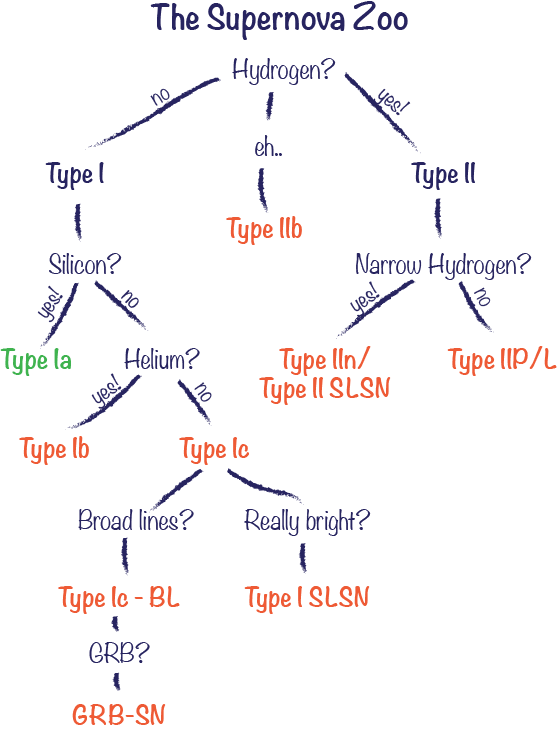


## Use the identified elements below to determine which elements are "in abundance" in your supernova.

In [ ]:
lines = {'H I': np.array([4101.73, 4340.47, 4861.35, 6562.82]),
         'He I': np.array([5875.62, 6678.15, 7065.19, 7281.35 ]),
         'Si II': np.array([5978.93, 6347.10]),
         'Ca II': np.array([3800, 8300 ]),
         'O I': np.array([7778]),
         'Fe II': np.array([4400])}

In [ ]:
plot_spectrum(spec, add_lines=lines, elements=['H I'])

# Try the other supernovae in our list

In [ ]:
spec = spectrum('2021pfs.csv')
plot_spectrum(spec)

In [ ]:
spec = spectrum('2016gkg.csv')
plot_spectrum(spec)

In [ ]:
spec = spectrum('2019yvr.csv')
plot_spectrum(spec)

In [ ]:
spec = spectrum('2020tlf.csv')
plot_spectrum(spec)

In [ ]:
spec = spectrum('2017ein.csv')
plot_spectrum(spec)

In [ ]:
spec = spectrum('2019abn.csv')
plot_spectrum(spec)

In [ ]:
spec = spectrum('2022mxv.csv')
plot_spectrum(spec)

# Reflect + Discuss

Prepare your case to present to the other group: 

*   What SN type is it?

I belive it to be a Type Ia SN
*   Why? How do you know?

I belive this because it has traces of Iron, Calcium, Silicon, and Oxygen. This matches with the emissons of Type Ia SN. 

Your justification should include mention of different metals, their relative abundances, matches to other supernova types, etc.


<br> Bonus question: What type of SN do you think is a close second place, if any? Was your classification a clear cut, or was it a little hard to decide? What do you think happens in this case?